In [2]:
#! pip uninstall torch torchvision torchaudio -y
#! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

import os
import cv2
import shutil
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4080


In [2]:
# sdir = 'Plants_2'
# img_size = (200,300)

# working_dir = r'./'
# dstdir = os.path.join(working_dir, 'resizedmerged')
# if os.path.isdir(dstdir):
#     shutil.rmtree(dstdir)
# os.mkdir(dstdir)

# filepaths = []
# labels = []
# plant_list = sorted(os.listdir(sdir))    
# for plant in plant_list:
#     plant_path = os.path.join(sdir, plant)
#     dst_plant_path = os.path.join(dstdir, plant)
#     os.mkdir(dst_plant_path)
#     classlist = sorted(os.listdir(plant_path))
    
#     for cl in classlist:
#         classpath = os.path.join(plant_path, cl)
#         dst_classpath = os.path.join(dst_plant_path, cl)
#         os.mkdir(dst_classpath)

#         # Only process if classpath is a directory
#         if os.path.isdir(classpath):  # Ensure classpath is a directory
#             flist = sorted(os.listdir(classpath))
#             desc = f'{plant:25s}-{cl:9s}'
            
#             for f in tqdm(flist, ncols=130, desc=desc, unit='files', colour='blue'):
#                 fpath = os.path.join(classpath, f)
#                 dst_fpath = os.path.join(dst_classpath, f)
                
#                 # Check if the file exists and is a valid image file
#                 if os.path.isfile(fpath):  # Ensure fpath is a file
#                     filepaths.append(dst_fpath)
#                     img = cv2.imread(fpath)
#                     img = cv2.resize(img, img_size)
#                     cv2.imwrite(dst_fpath, img)
#                     labels.append(plant + '-' + cl)

            
# Fseries = pd.Series(filepaths, name = 'filepaths')
# Lseries = pd.Series(labels, name = 'labels')
# df = pd.concat([Fseries, Lseries], axis = 1)

In [ ]:
# df.to_csv('data.csv', index = False)
import pandas as pd
df = pd.read_csv('data.csv')
df['labels'] = df['labels'].apply(lambda x: x.split('-')[1])


from sklearn.model_selection import train_test_split

print(df['labels'])

0       Alstonia Scholaris diseased (P2a)
1       Alstonia Scholaris diseased (P2a)
2       Alstonia Scholaris diseased (P2a)
3       Alstonia Scholaris diseased (P2a)
4       Alstonia Scholaris diseased (P2a)
                      ...                
4489       Pongamia Pinnata healthy (P7a)
4490       Pongamia Pinnata healthy (P7a)
4491       Pongamia Pinnata healthy (P7a)
4492       Pongamia Pinnata healthy (P7a)
4493       Pongamia Pinnata healthy (P7a)
Name: labels, Length: 4494, dtype: object


In [7]:
df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df['labels'], random_state = 42, shuffle = True)
df_train, df_val = train_test_split(df_train, test_size = 0.2, stratify = df_train['labels'], random_state = 42, shuffle = True)

# df_train = df[df['filepaths'].str.contains('train')]
# df_val = df[df['filepaths'].str.contains('val')]
# df_test = df[df['filepaths'].str.contains('test')]

In [8]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [9]:
classes = sorted(df_train['labels'].unique())
class_count = len(classes)    
print('number of classes in processed dataset =', class_count)

counts = list(df_train['labels'].value_counts())
print('the maximum files in any class in df_train is ', max(counts), '  the minimum files in any class in df_train is ', min(counts))
print('df_train length: ', len(df_train), '  df_test length: ', len(df_test), '  df_val length: ', len(df_val))

# return df_train, df_test, df_val, classes, class_count
# df_train, df_test, df_val, classes, class_count = make_dataframes(sdir, img_size)
print(classes)

number of classes in processed dataset = 22
the maximum files in any class in df_train is  221   the minimum files in any class in df_train is  50
df_train length:  2876   df_test length:  899   df_val length:  719
['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun diseased (P1a)', 'Arjun healthy (P1b)', 'Bael diseased (P4b)', 'Basil healthy (P8)', 'Chinar diseased (P11b)', 'Chinar healthy (P11a)', 'Gauva diseased (P3b)', 'Gauva healthy (P3a)', 'Jamun diseased (P5b)', 'Jamun healthy (P5a)', 'Jatropha diseased (P6b)', 'Jatropha healthy (P6a)', 'Lemon diseased (P10b)', 'Lemon healthy (P10a)', 'Mango diseased (P0b)', 'Mango healthy (P0a)', 'Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)', 'Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']


In [7]:
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torch.utils.data import Dataset
from PIL import Image

# Dataset class (no changes here)
class LeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name).convert("RGB")  # Ensure RGB mode
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET),  # Boosts generalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentation for val/test
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_data(df, transform):
    dataset = LeafDataset(df, transform=transform)
    return dataset

train_dataset = load_data(df_train, transform=train_transform)
val_dataset = load_data(df_val, transform=val_test_transform)
test_dataset = load_data(df_test, transform=val_test_transform)


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])  # this must be strings!

# Now transform splits
df_train.loc[:, 'labels'] = label_encoder.transform(df_train['labels'])
df_val.loc[:, 'labels'] = label_encoder.transform(df_val['labels'])
df_test.loc[:, 'labels'] = label_encoder.transform(df_test['labels'])



train_dataset = load_data(df_train, transform=train_transform)
val_dataset = load_data(df_val, transform=val_test_transform)
test_dataset = load_data(df_test, transform=val_test_transform)


#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(weights='DEFAULT')
#model = model.to(device)

for param in model.features.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, len(label_encoder.classes_))
)

model = model.to(device)

for name, param in model.named_parameters():
    if "features.3" in name or "features.4" in name or "features.5" in name or "features.6" in name or "classifier" in name:
        param.requires_grad = True




#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for name, param in model.named_parameters():
    print(f"{name} -> {param.device}")



features.0.0.weight -> cuda:0
features.0.1.weight -> cuda:0
features.0.1.bias -> cuda:0
features.1.0.block.0.0.weight -> cuda:0
features.1.0.block.0.1.weight -> cuda:0
features.1.0.block.0.1.bias -> cuda:0
features.1.0.block.1.fc1.weight -> cuda:0
features.1.0.block.1.fc1.bias -> cuda:0
features.1.0.block.1.fc2.weight -> cuda:0
features.1.0.block.1.fc2.bias -> cuda:0
features.1.0.block.2.0.weight -> cuda:0
features.1.0.block.2.1.weight -> cuda:0
features.1.0.block.2.1.bias -> cuda:0
features.2.0.block.0.0.weight -> cuda:0
features.2.0.block.0.1.weight -> cuda:0
features.2.0.block.0.1.bias -> cuda:0
features.2.0.block.1.0.weight -> cuda:0
features.2.0.block.1.1.weight -> cuda:0
features.2.0.block.1.1.bias -> cuda:0
features.2.0.block.2.fc1.weight -> cuda:0
features.2.0.block.2.fc1.bias -> cuda:0
features.2.0.block.2.fc2.weight -> cuda:0
features.2.0.block.2.fc2.bias -> cuda:0
features.2.0.block.3.0.weight -> cuda:0
features.2.0.block.3.1.weight -> cuda:0
features.2.0.block.3.1.bias -> c

In [10]:
import numpy as np
import torch

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [11]:
num_epochs = 25
from torch.optim.lr_scheduler import OneCycleLR
best_val_acc = 0.0  # Best validation accuracy tracker

steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=0.001, epochs=num_epochs, steps_per_epoch=steps_per_epoch)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.2)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracies.append((correct_train/total_train) * 100)
    val_accuracies.append((correct_val/total_val) * 100)


    # Save best model based on validation accuracy
    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ New best model saved with val acc: {:.2f}%".format(best_val_acc))


    print(
        f"Epoch {epoch+1}/{num_epochs},",
        f"Train Loss: {train_losses[-1]:.4f},",
        f"Val Loss: {val_losses[-1]:.4f},",
        f"Train Acc: {train_accuracies[-1]:.2f}%,",
        f"Val Acc: {val_accuracies[-1]:.2f}%"
    )

    scheduler.step(val_loss)

    if epoch > 1 and val_losses[-1] > val_losses[-2] and val_losses[-2] > val_losses[-3]:
        print("Validation loss increasing. Stopping early.")
        break

now = datetime.datetime.now()
timestamp = now.strftime("%m-%d_%H-%M-%S")
model_name = f"efficientnet_{timestamp}.pth"
torch.save(model.state_dict(), model_name)


✅ New best model saved with val acc: 36.16%
Epoch 1/25, Train Loss: 3.0246, Val Loss: 2.7738, Train Acc: 8.83%, Val Acc: 36.16%


c:\Users\20200306\.conda\envs\tf-gpu-3.10\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


✅ New best model saved with val acc: 55.91%
Epoch 2/25, Train Loss: 2.8133, Val Loss: 2.1965, Train Acc: 15.72%, Val Acc: 55.91%
✅ New best model saved with val acc: 65.79%
Epoch 3/25, Train Loss: 2.5110, Val Loss: 1.7665, Train Acc: 22.04%, Val Acc: 65.79%
✅ New best model saved with val acc: 70.93%
Epoch 4/25, Train Loss: 2.2638, Val Loss: 1.5125, Train Acc: 26.81%, Val Acc: 70.93%
✅ New best model saved with val acc: 78.30%
Epoch 5/25, Train Loss: 2.0952, Val Loss: 1.3189, Train Acc: 31.02%, Val Acc: 78.30%
✅ New best model saved with val acc: 82.48%
Epoch 6/25, Train Loss: 1.9946, Val Loss: 1.1838, Train Acc: 35.12%, Val Acc: 82.48%
✅ New best model saved with val acc: 84.98%
Epoch 7/25, Train Loss: 1.8460, Val Loss: 1.0958, Train Acc: 40.65%, Val Acc: 84.98%
✅ New best model saved with val acc: 87.48%
Epoch 8/25, Train Loss: 1.7467, Val Loss: 1.0023, Train Acc: 37.93%, Val Acc: 87.48%
✅ New best model saved with val acc: 87.90%
Epoch 9/25, Train Loss: 1.7217, Val Loss: 0.9539, Tra

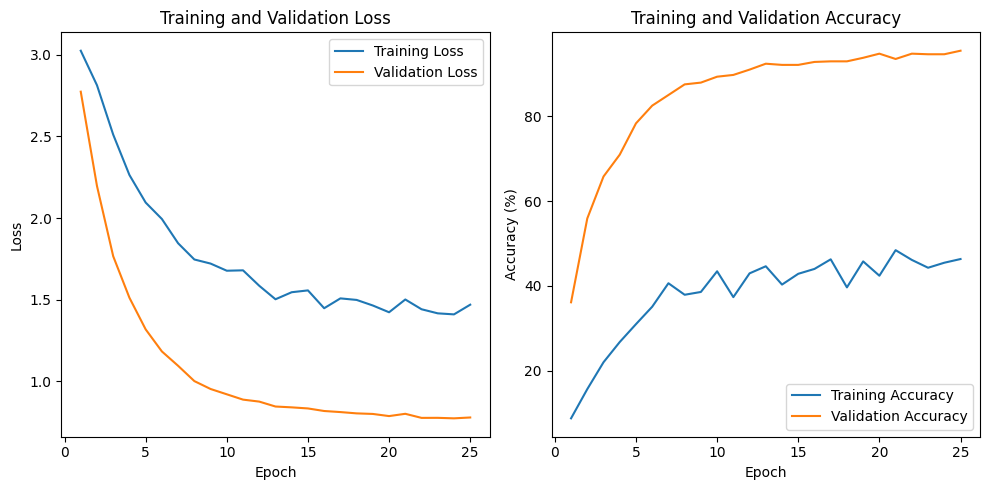

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(train_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(train_losses) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct/total) * 100
# model.load_state_dict(torch.load(model_name))

model.load_state_dict(torch.load("best_model.pth"))

test_accuracy = test_model(model, test_loader)
print(f"Test accuracy: {test_accuracy:.2f}%")
    



C:\Users\20200306\AppData\Local\Temp\ipykernel_13924\2853079972.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test accuracy: 95.77%


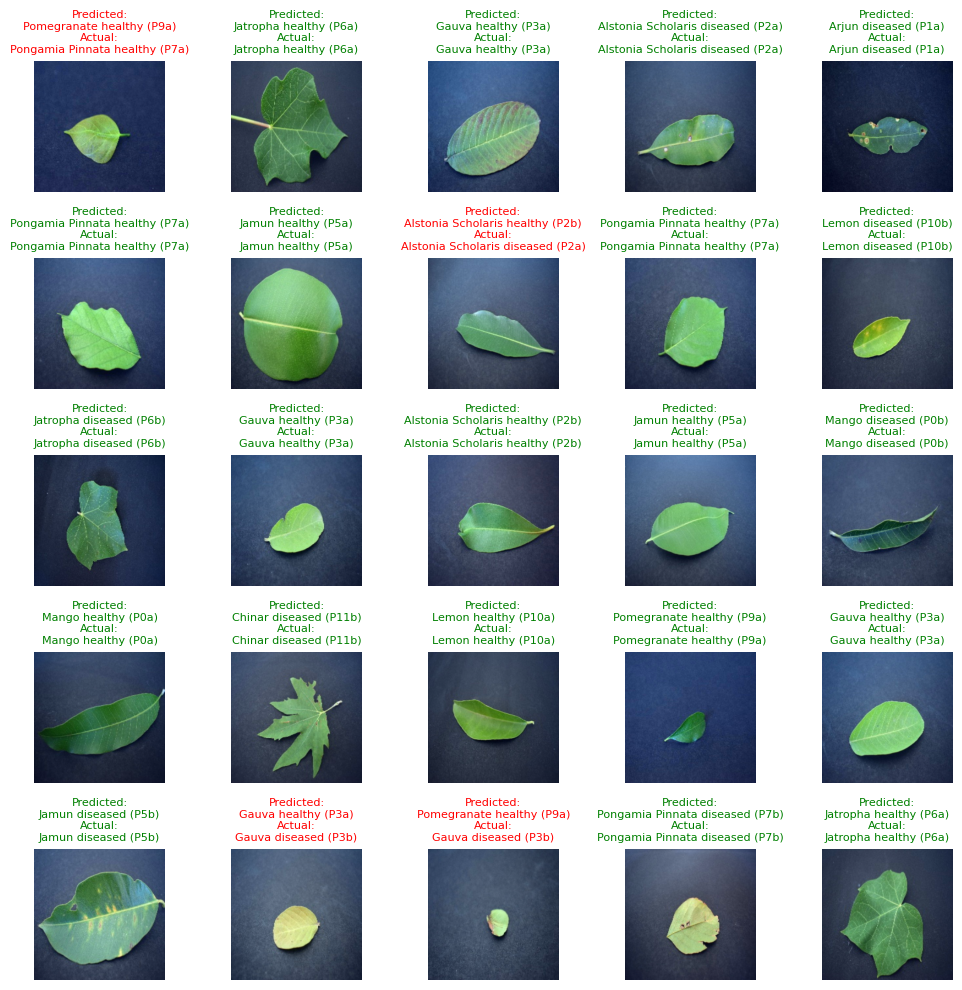

In [ ]:
def predict_and_plot(model, test_loader, label_encoder):
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))

    test_loader.dataset.data = test_loader.dataset.data.sample(frac=1).reset_index(drop=True)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if images_so_far >= 25:
                    break
                ax = axs[images_so_far // 5, images_so_far % 5]
                ax.axis('off')
                color = 'green' if predicted[i] == labels[i] else 'red'
                ax.set_title(f'Predicted:\n{label_encoder.classes_[predicted[i]]}\nActual:\n{label_encoder.classes_[labels[i]]}', color=color, fontsize=8)

                img_np = inputs.cpu().data[i].permute(1, 2, 0).numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
                ax.imshow(img_np)
                images_so_far += 1

            if images_so_far >= 25:
                break

    plt.tight_layout()
    plt.show()

predict_and_plot(model, test_loader, label_encoder)
